# Training Samples loader
This notebook contains the example code of loading the positive and negative pairs saved in file pairs.h5py.

In [1]:
# package need to be installed
# pip install ipykernel
# pip install opencv-python
# pip install scikit-learn

In [2]:
import os
import numpy as np
import cv2
import h5py
import torch
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
def load_pairs_from_hdf5(hdf5_file_path, hdf5_folder):
    with h5py.File(hdf5_file_path, 'r') as hdf:
        loaded_pairs = []

        # Function to convert a single relative path back to an absolute path
        def make_absolute(rel_path):
            # Decode if the path is a byte string
            if isinstance(rel_path, bytes):
                rel_path = rel_path.decode('utf-8')
            return os.path.join(hdf5_folder, rel_path)

        # Function to process paths in pairs
        def process_paths(img_paths_array):
            # Ensure each path in the tuple is absolute
            return tuple(make_absolute(path) for path in img_paths_array)

        # Load pairs
        pairs_group = hdf['pairs']
        for pair_name in pairs_group:
            pair_group = pairs_group[pair_name]
            img_paths_array = pair_group['img_paths'][()]  # This will be a NumPy array
            img_paths = process_paths(img_paths_array)  # Process each path to be absolute
            points1 = torch.tensor(pair_group['points1'][()])
            pos_points2 = torch.tensor(pair_group['pos_points2'][()])
            neg_points2 = torch.tensor(pair_group['neg_points2'][()])
            loaded_pairs.append({
                'img_paths': img_paths, 
                'points1': points1, 
                'pos_points2': pos_points2, 
                'neg_points2': neg_points2
            })

    return loaded_pairs

In [4]:
# Get the current working directory
current_directory = os.getcwd()
output_path = os.path.join(current_directory, os.pardir, os.pardir,'sun3d_training')
hdf5_file_path = os.path.join(output_path, 'pairs.hdf5')

In [5]:
loaded_pairs= load_pairs_from_hdf5(hdf5_file_path,output_path)

Ramdomly pick a pos pair and neg pair for visualizaiont.

In [6]:
def visualize_points_side_by_side(idx, pairs):
    if not pairs:
        print("No pairs to display.")
        return

    # Decode byte strings for image paths
    pos_img_path,neg_img_path = pairs[idx]['img_paths']

    # Load images and convert to RGB
    pos_img = cv2.cvtColor(cv2.imread(pos_img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    neg_img = cv2.cvtColor(cv2.imread(neg_img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    # Combine the images horizontally for ax1
    combined_img = np.hstack((pos_img, neg_img))

    # Create a figure with 1 row and 2 columns for subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.imshow(combined_img)
    ax1.set_title("Positive Pair")

    # Draw green lines for positive points
    for p1, p2 in zip(pairs[idx]['points1'], pairs[idx]['pos_points2']):
        ax1.scatter(p1[0], p1[1], color='g', s=10)  # Green for positive points in the first image
        ax1.scatter(p2[0] + pos_img.shape[1], p2[1], color='g', s=10)  # Offset by img1 width for alignment
        
    ax1.axis('off')

    ax2.imshow(combined_img)
    ax2.set_title("Negative Pair")
    for p3, p4 in zip(pairs[idx]['points1'], pairs[idx]['neg_points2']):
        ax2.scatter(p3[0], p3[1], color='r', s=10)  
        ax2.scatter(p4[0] + pos_img.shape[1], p4[1], color='r', s=10)  # Red for negative points in the second image
    

    ax2.axis('off')

    plt.show()

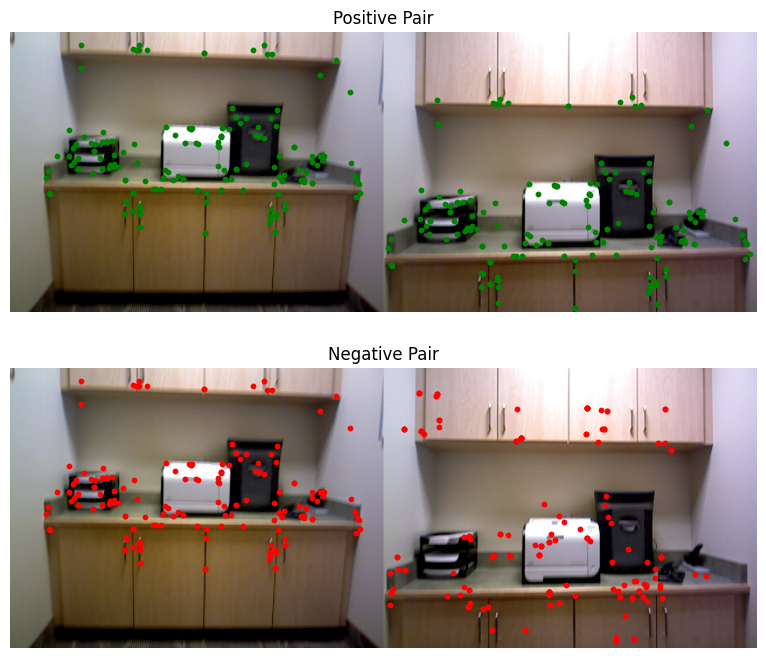

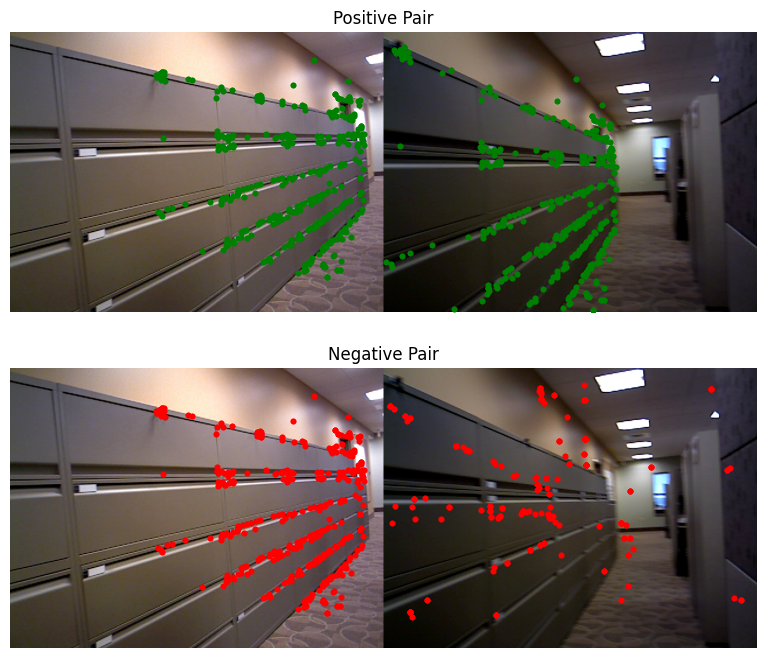

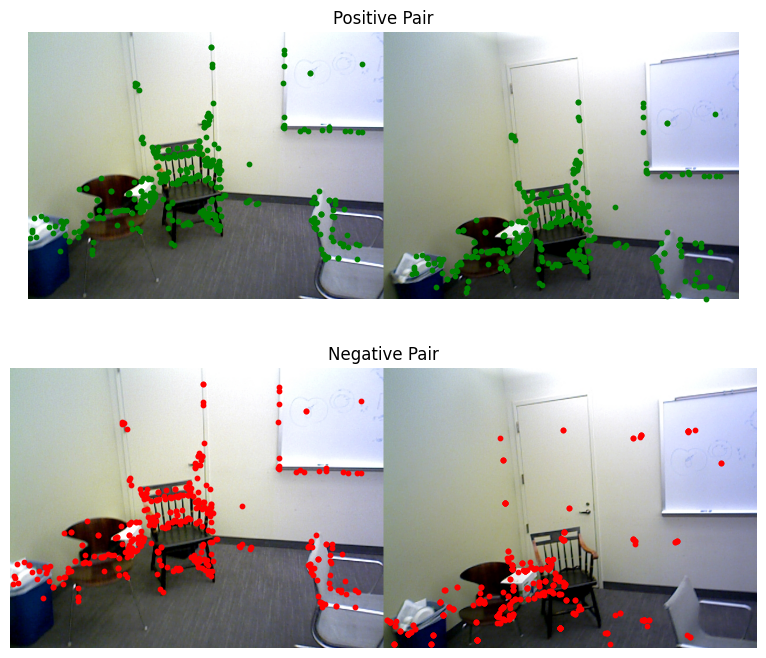

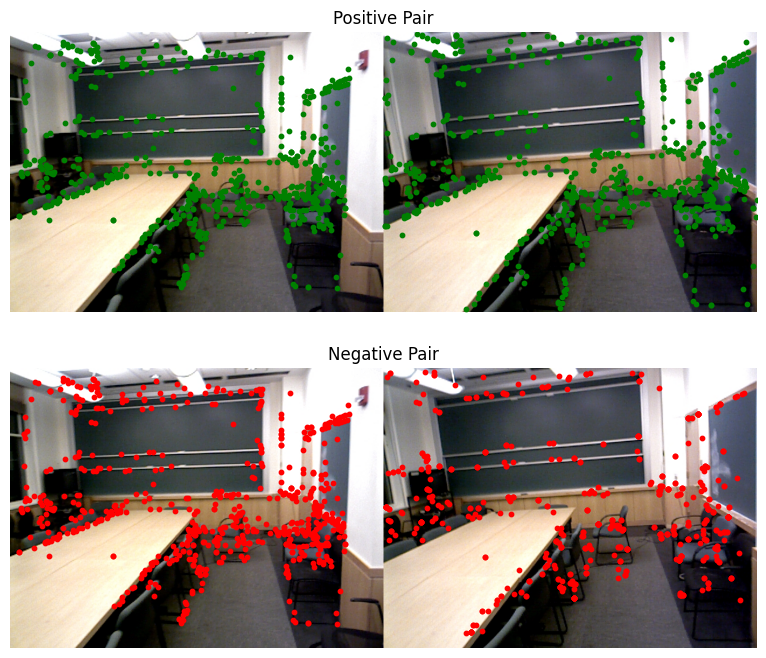

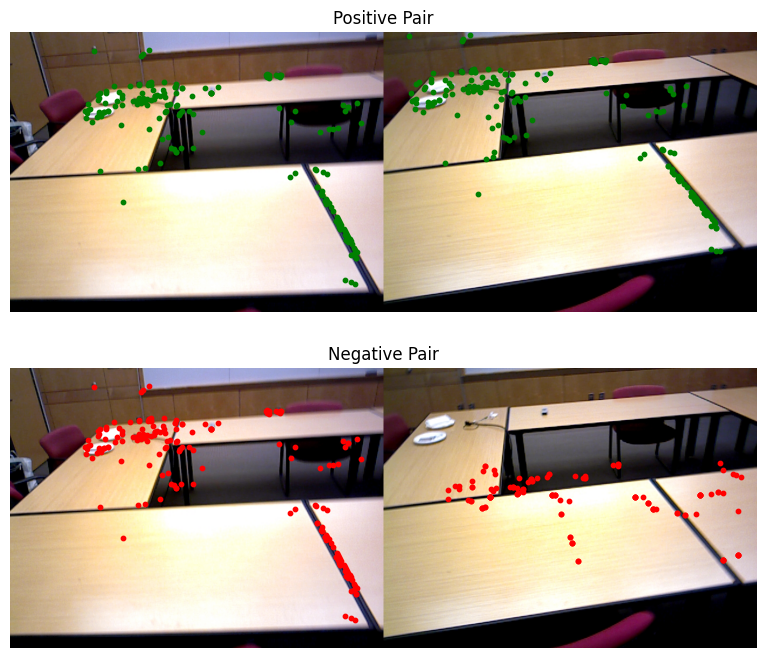

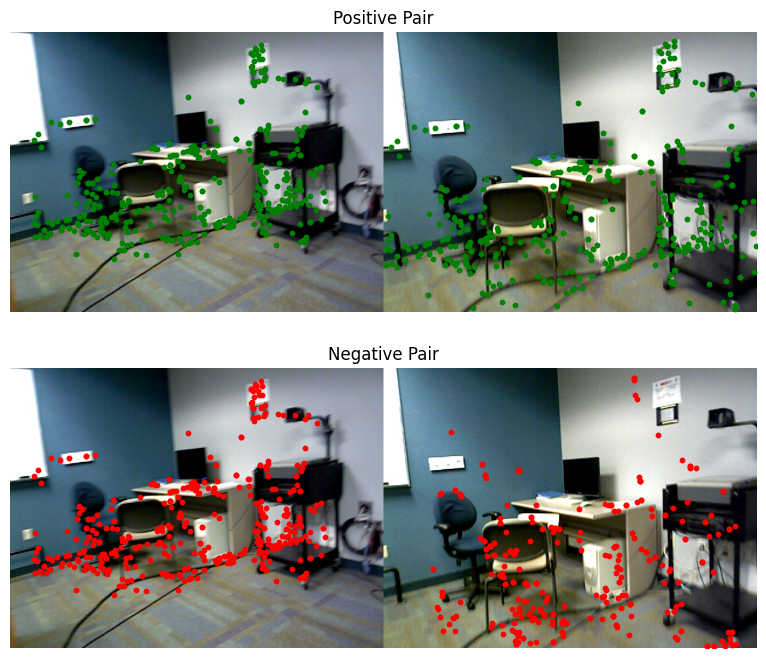

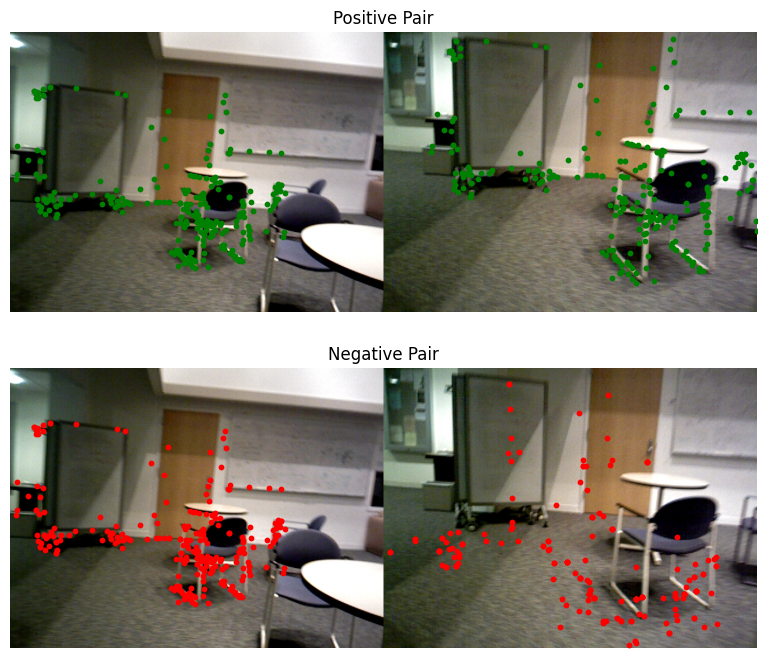

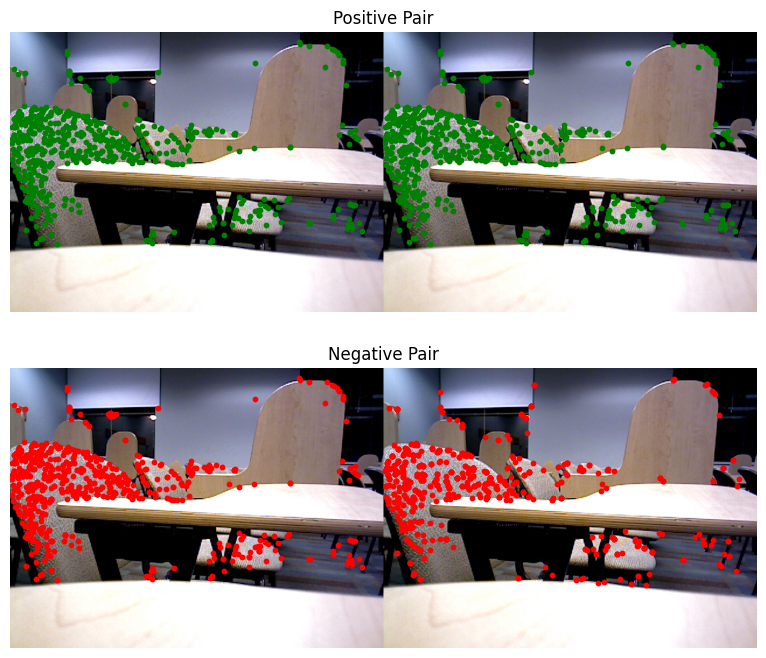

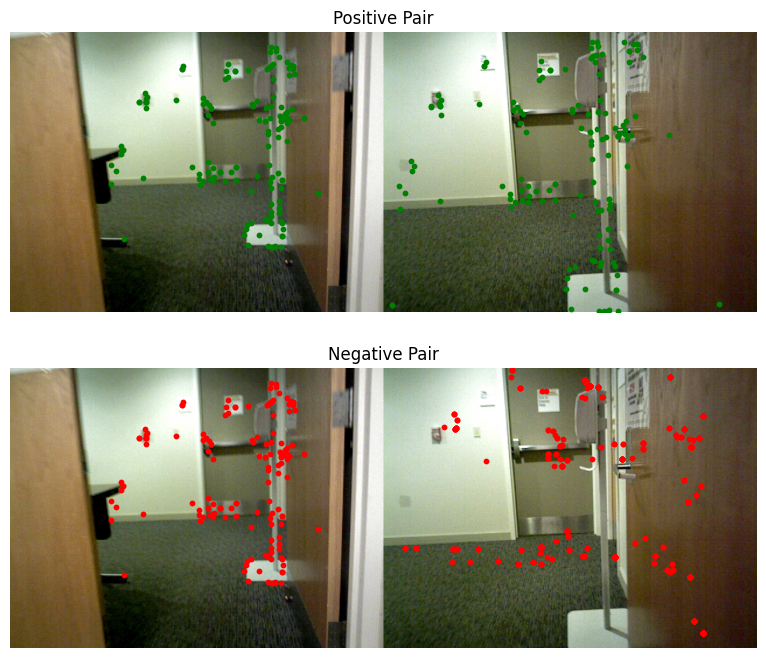

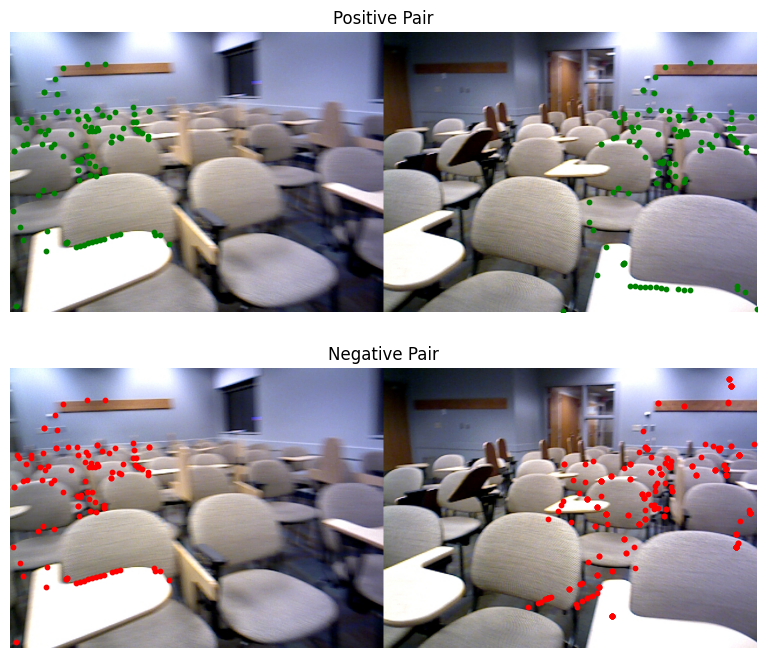

In [7]:
# Generate a list of indices for the positive_pairs
indices = range(len(loaded_pairs))

# Sample 10 indices
sampled_indices = random.sample(indices, min(10, len(indices)))

for idx in sampled_indices:
    visualize_points_side_by_side(idx, loaded_pairs)